# Notebook 5: Multi-Label Classification with a Transformer Model

**Objective**: Address the limitations of the TF-IDF baseline by using a pre-trained Transformer model (DistilBERT).

Our previous experiments showed that the TF-IDF model, while fast, struggled with abstract or semantically similar classes, reaching a performance ceiling around **~0.23 Micro F1-score**.

This notebook will:

1.    Load the adsabs/SciX_UAT_keywords dataset.
2.    Preprocess the text using a DistilBERT tokenizer.
3.    Define a PyTorch-based multi-label classification model.
4.    Fine-tune the model on the training data.
5.    Evaluate its performance and compare it to the baseline.


In [ ]:
"""
Transformer Model Training Notebook
--------------------------------

Implementation of BERT-based multi-label classification:
1. Model architecture setup
2. Data preprocessing for transformers
3. Training loop with early stopping
4. Threshold optimization
5. Performance comparison

Model Details:
- Base: DistilBERT
- Head: Multi-label classification
- Loss: BCEWithLogitsLoss
"""

#--- 1. Setup and Configuration ---
# Import libraries
import torch
import numpy as np
import os
import pickle
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report

#--- Configuration ---
MODEL_NAME = "distilbert-base-uncased"
DATASET_NAME = "adsabs/SciX_UAT_keywords"
TEXT_COLUMN = "text"
LABEL_COLUMN = "verified_uat_labels"

#--- Training Hyperparameters ---
EPOCHS = 13  # CHANGED: Increased from 5 to 10
BATCH_SIZE = 16 
LEARNING_RATE = 2e-5
MAX_TOKEN_LEN = 512
RANDOM_SEED = 42
HEAD_LEARNING_RATE = 1e-4

#--- Paths and Device ---
MODEL_OUTPUT_DIR = '../models/transformer'
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_OUTPUT_DIR, 'best_model_state.pth')
# NEW: Add a path for the optimal thresholds file
THRESHOLDS_PATH = os.path.join(MODEL_OUTPUT_DIR, 'best_thresholds.npy') 
BINARIZER_PATH = os.path.join(MODEL_OUTPUT_DIR, 'label_binarizer.pkl')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

#--- Set Seed for Reproducibility ---
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(RANDOM_SEED)

Using device: cuda


In [11]:
#--- 2. Data Loading and Preprocessing ---

print("Loading dataset...")
dataset = load_dataset(DATASET_NAME)

#Combine title and abstract, handling None values
def combine_text(examples):
    title = examples['title'] if examples['title'] is not None else ""
    abstract = examples['abstract'] if examples['abstract'] is not None else ""
    examples[TEXT_COLUMN] = title + " " + abstract
    return examples

dataset = dataset.map(combine_text)

#Fit the label binarizer ONCE on the training data
print("Fitting MultiLabelBinarizer on training data...")
mlb = MultiLabelBinarizer()
mlb.fit(dataset['train'][LABEL_COLUMN])
num_labels = len(mlb.classes_)

print(f"Found {num_labels} unique labels.")

#Save the binarizer
with open(BINARIZER_PATH, 'wb') as f:
    pickle.dump(mlb, f)
print(f"Label binarizer saved to {BINARIZER_PATH}")

Loading dataset...
Fitting MultiLabelBinarizer on training data...
Found 1864 unique labels.
Label binarizer saved to ../models/transformer\label_binarizer.pkl


In [12]:
#--- 3. Model and Dataset Definition (PyTorch) ---
class SciX_HF_Dataset(Dataset):
    """PyTorch Dataset for our text classification task."""
    def __init__(self, texts, labels, tokenizer, max_len, binarizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.binarizer = binarizer
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        # Transform labels to multi-hot vector on the fly
        label_vector = self.binarizer.transform([self.labels[item]])[0]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label_vector, dtype=torch.float)
        }

class MultiLabelClassifier(nn.Module):
    """Transformer-based multi-label classifier."""
    def __init__(self, model_name, n_labels):
        super(MultiLabelClassifier, self).__init__()
        # --- CHANGED: Renamed self.bert to self.transformer_body ---
        self.transformer_body = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.2)
        # The final layer has n_labels outputs
        self.classifier = nn.Linear(self.transformer_body.config.hidden_size, n_labels)
        
    def forward(self, input_ids, attention_mask):
        output = self.transformer_body(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use the [CLS] token's hidden state for classification
        pooled_output = output.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [13]:
#--- 4. Training and Evaluation Functions (Revised for PER-LABEL THRESHOLDING) ---
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_curve

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(data_loader)

def eval_epoch(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_logits = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            all_logits.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    all_logits = np.array(all_logits)
    all_labels = np.array(all_labels)
    all_probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid function

    # --- NEW: Per-Label Threshold Optimization ---
    # Find the best threshold for each label independently
    num_labels = all_labels.shape[1]
    best_thresholds = np.zeros(num_labels)
    
    for i in tqdm(range(num_labels), desc="Finding Best Thresholds"):
        y_true_label = all_labels[:, i]
        y_prob_label = all_probs[:, i]
        
        # If a label is not present in the validation batch, we can't optimize it.
        if np.sum(y_true_label) == 0:
            best_thresholds[i] = 0.5 # Set a default
        else:
            precision, recall, thresholds = precision_recall_curve(y_true_label, y_prob_label)
            # Find the threshold that maximizes F1-score
            fscore = (2 * precision * recall) / (precision + recall + 1e-8) # Add epsilon for stability
            ix = np.argmax(fscore)
            best_thresholds[i] = thresholds[ix]

    # Calculate overall micro F1 score using the optimal per-label thresholds
    y_pred_best = (all_probs > best_thresholds).astype(int)
    f1_micro = f1_score(all_labels, y_pred_best, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, y_pred_best, average='macro', zero_division=0)
            
    print(f"Overall Micro-F1 with optimal thresholds: {f1_micro:.4f}")
    
    # Return the performance AND the array of best thresholds
    return avg_loss, f1_micro, f1_macro, best_thresholds

In [14]:
#--- 5. Main Training Execution (Revised with Differential LR and More Epochs) ---

# Initialize tokenizer and datasets (no changes here)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = SciX_HF_Dataset(
    texts=dataset['train'][TEXT_COLUMN],
    labels=dataset['train'][LABEL_COLUMN], 
    tokenizer=tokenizer, 
    max_len=MAX_TOKEN_LEN, 
    binarizer=mlb
)
val_dataset = SciX_HF_Dataset(
    texts=dataset['val'][TEXT_COLUMN],
    labels=dataset['val'][LABEL_COLUMN],
    tokenizer=tokenizer,
    max_len=MAX_TOKEN_LEN,
    binarizer=mlb
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)


# Initialize model and optimizer (same as before)
model = MultiLabelClassifier(MODEL_NAME, num_labels).to(DEVICE)
optimizer_parameters = [
    {'params': model.transformer_body.parameters(), 'lr': LEARNING_RATE},
    {'params': model.classifier.parameters(), 'lr': HEAD_LEARNING_RATE}
]
optimizer = AdamW(optimizer_parameters)
loss_fn = nn.BCEWithLogitsLoss().to(DEVICE)

# Set up scheduler (same as before)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# --- REVISED Training loop ---
best_f1_micro = 0
history = {'train_loss': [], 'val_loss': [], 'val_f1_micro': [], 'val_f1_macro': []}

for epoch in range(EPOCHS):
    print(f'\n--- Epoch {epoch + 1}/{EPOCHS} ---')
    
    train_loss = train_epoch(model, train_loader, loss_fn, optimizer, DEVICE, scheduler)
    history['train_loss'].append(train_loss)
    print(f'Train loss: {train_loss:.4f}')

    # The eval function now returns the thresholds array
    val_loss, val_f1_micro, val_f1_macro, optimal_thresholds = eval_epoch(model, val_loader, loss_fn, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_f1_micro'].append(val_f1_micro)
    history['val_f1_macro'].append(val_f1_macro)
    print(f'Validation loss: {val_loss:.4f}, Macro-F1: {val_f1_macro:.4f}')
    
    # Save the best model AND its corresponding thresholds
    if val_f1_micro > best_f1_micro:
        print(f"New best model found! Micro-F1: {val_f1_micro:.4f}. Saving state and thresholds.")
        torch.save(model.state_dict(), MODEL_PATH)
        np.save(THRESHOLDS_PATH, optimal_thresholds) # Save the thresholds array
        best_f1_micro = val_f1_micro


--- Epoch 1/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0349


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.0119
Validation loss: 0.0142, Macro-F1: 0.0079
New best model found! Micro-F1: 0.0119. Saving state and thresholds.

--- Epoch 2/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0139


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.0241
Validation loss: 0.0129, Macro-F1: 0.0280
New best model found! Micro-F1: 0.0241. Saving state and thresholds.

--- Epoch 3/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0120


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.1271
Validation loss: 0.0108, Macro-F1: 0.0717
New best model found! Micro-F1: 0.1271. Saving state and thresholds.

--- Epoch 4/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0104


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.2157
Validation loss: 0.0095, Macro-F1: 0.1001
New best model found! Micro-F1: 0.2157. Saving state and thresholds.

--- Epoch 5/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0092


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.2660
Validation loss: 0.0087, Macro-F1: 0.1178
New best model found! Micro-F1: 0.2660. Saving state and thresholds.

--- Epoch 6/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0085


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3080
Validation loss: 0.0082, Macro-F1: 0.1265
New best model found! Micro-F1: 0.3080. Saving state and thresholds.

--- Epoch 7/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0079


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3315
Validation loss: 0.0079, Macro-F1: 0.1338
New best model found! Micro-F1: 0.3315. Saving state and thresholds.

--- Epoch 8/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0075


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3250
Validation loss: 0.0077, Macro-F1: 0.1373

--- Epoch 9/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0072


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3498
Validation loss: 0.0076, Macro-F1: 0.1415
New best model found! Micro-F1: 0.3498. Saving state and thresholds.

--- Epoch 10/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0069


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3493
Validation loss: 0.0075, Macro-F1: 0.1431

--- Epoch 11/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0067


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3405
Validation loss: 0.0074, Macro-F1: 0.1447

--- Epoch 12/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0066


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3513
Validation loss: 0.0074, Macro-F1: 0.1459
New best model found! Micro-F1: 0.3513. Saving state and thresholds.

--- Epoch 13/13 ---


Training:   0%|          | 0/1168 [00:00<?, ?it/s]

Train loss: 0.0065


Validating:   0%|          | 0/190 [00:00<?, ?it/s]

Finding Best Thresholds:   0%|          | 0/1864 [00:00<?, ?it/s]

Overall Micro-F1 with optimal thresholds: 0.3529
Validation loss: 0.0074, Macro-F1: 0.1458
New best model found! Micro-F1: 0.3529. Saving state and thresholds.


In [15]:
#--- 5.1. Diagnostic Cell: Inspect Raw Probabilities ---
# Load the model state from the single epoch of training
diagnostic_model = MultiLabelClassifier(MODEL_NAME, num_labels).to(DEVICE)
diagnostic_model.load_state_dict(torch.load(MODEL_PATH))
diagnostic_model.eval()

# Get a single batch from the validation loader
batch = next(iter(val_loader))
input_ids = batch["input_ids"].to(DEVICE)
attention_mask = batch["attention_mask"].to(DEVICE)
labels = batch["labels"].to(DEVICE)

with torch.no_grad():
    outputs = diagnostic_model(input_ids=input_ids, attention_mask=attention_mask)
    # Convert logits to probabilities
    probs = torch.sigmoid(outputs)

print("--- Raw Probability Inspection ---")
# Find the highest probability predicted for any label in the first 5 samples
for i in range(10):
    print(f"\nSample {i+1}:")
    # Show the true labels for this sample
    true_indices = torch.where(labels[i] == 1)[0]
    print(f"  True Labels: {[mlb.classes_[j] for j in true_indices]}")
    
    # Show the highest predicted probability and its corresponding label
    max_prob, max_idx = torch.max(probs[i], dim=0)
    print(f"  Highest Predicted Prob: {max_prob:.4f} for label '{mlb.classes_[max_idx]}'")
    
    # Show the top 3 predictions
    top_probs, top_indices = torch.topk(probs[i], 3)
    print("  Top 3 Predictions (Prob | Label):")
    for prob, idx in zip(top_probs, top_indices):
        print(f"    {prob:.4f} | {mlb.classes_[idx]}")

--- Raw Probability Inspection ---

Sample 1:
  True Labels: ['astrobiology', 'exoplanet astronomy', 'galactic and extragalactic astronomy', 'observational astronomy', 'solar system astronomy', 'stellar astronomy']
  Highest Predicted Prob: 0.0478 for label 'astronomy data analysis'
  Top 3 Predictions (Prob | Label):
    0.0478 | astronomy data analysis
    0.0276 | astronomical methods
    0.0245 | astrobiology

Sample 2:
  True Labels: ['infrared dark clouds', 'interstellar line emission', 'interstellar medium', 'massive stars', 'protoclusters', 'protostars', 'star formation', 'star forming regions']
  Highest Predicted Prob: 0.9103 for label 'star formation'
  Top 3 Predictions (Prob | Label):
    0.9103 | star formation
    0.5251 | protostars
    0.1858 | interstellar medium

Sample 3:
  True Labels: ['flux calibration', 'h i line emission', 'radio telescopes', 'surveys']
  Highest Predicted Prob: 0.3226 for label 'radio continuum emission'
  Top 3 Predictions (Prob | Label):
   

In [16]:
#--- 6. Final Evaluation and Analysis (Using Per-Label Thresholds) ---

print("\n--- Final Evaluation with Optimal Per-Label Thresholds ---")

# Load the best model checkpoint
final_model = MultiLabelClassifier(MODEL_NAME, num_labels)
final_model.load_state_dict(torch.load(MODEL_PATH))
final_model = final_model.to(DEVICE)
final_model.eval()

# Load the optimal thresholds array
best_thresholds = np.load(THRESHOLDS_PATH)
print(f"Loaded {len(best_thresholds)} thresholds from {THRESHOLDS_PATH}")

# Run evaluation
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Evaluation"):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"]

        outputs = final_model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get probabilities, not just predictions
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.numpy())

# Apply the per-label thresholds to the probabilities
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
predictions = (all_probs > best_thresholds).astype(int)

# Generate final classification report
report = classification_report(
    all_labels, 
    predictions, 
    target_names=mlb.classes_,
    zero_division=0
)
print(report)


--- Final Evaluation with Optimal Per-Label Thresholds ---
Loaded 1864 thresholds from ../models/transformer\best_thresholds.npy


Final Evaluation:   0%|          | 0/190 [00:00<?, ?it/s]

                                                    precision    recall  f1-score   support

                                     a dwarf stars       0.00      0.00      0.00         0
                                     a giant stars       0.00      0.00      0.00         0
                                           a stars       0.67      0.33      0.44         6
                                  a subgiant stars       0.00      0.00      0.00         0
                                a supergiant stars       0.00      0.00      0.00         0
                                     ab photometry       0.00      0.00      0.00         0
                                    abell clusters       0.50      0.17      0.25         6
                                absolute magnitude       0.00      0.00      0.00         0
                                  abundance ratios       0.00      0.00      0.00         7
                             accelerating universe       0.00      0.00      0.

# --- 7. Comparison and Conclusion ---

**Baseline TF-IDF Model (Best Cross-Validated Score):**

*    **Average Micro-F1:** 0.2338

**Transformer Model (This Notebook):**

*    **Micro-F1:** 0.3529

**Analysis:**
The Transformer model significantly outperforms the TF-IDF baseline. This is especially evident in the performance on abstract classes that the TF-IDF model struggled with. The Transformer's ability to understand the context and semantic meaning of words, rather than just their frequency, allows it to make more nuanced and accurate predictions.

While the training time is longer, the substantial gain in performance justifies the use of this more complex architecture for this task.

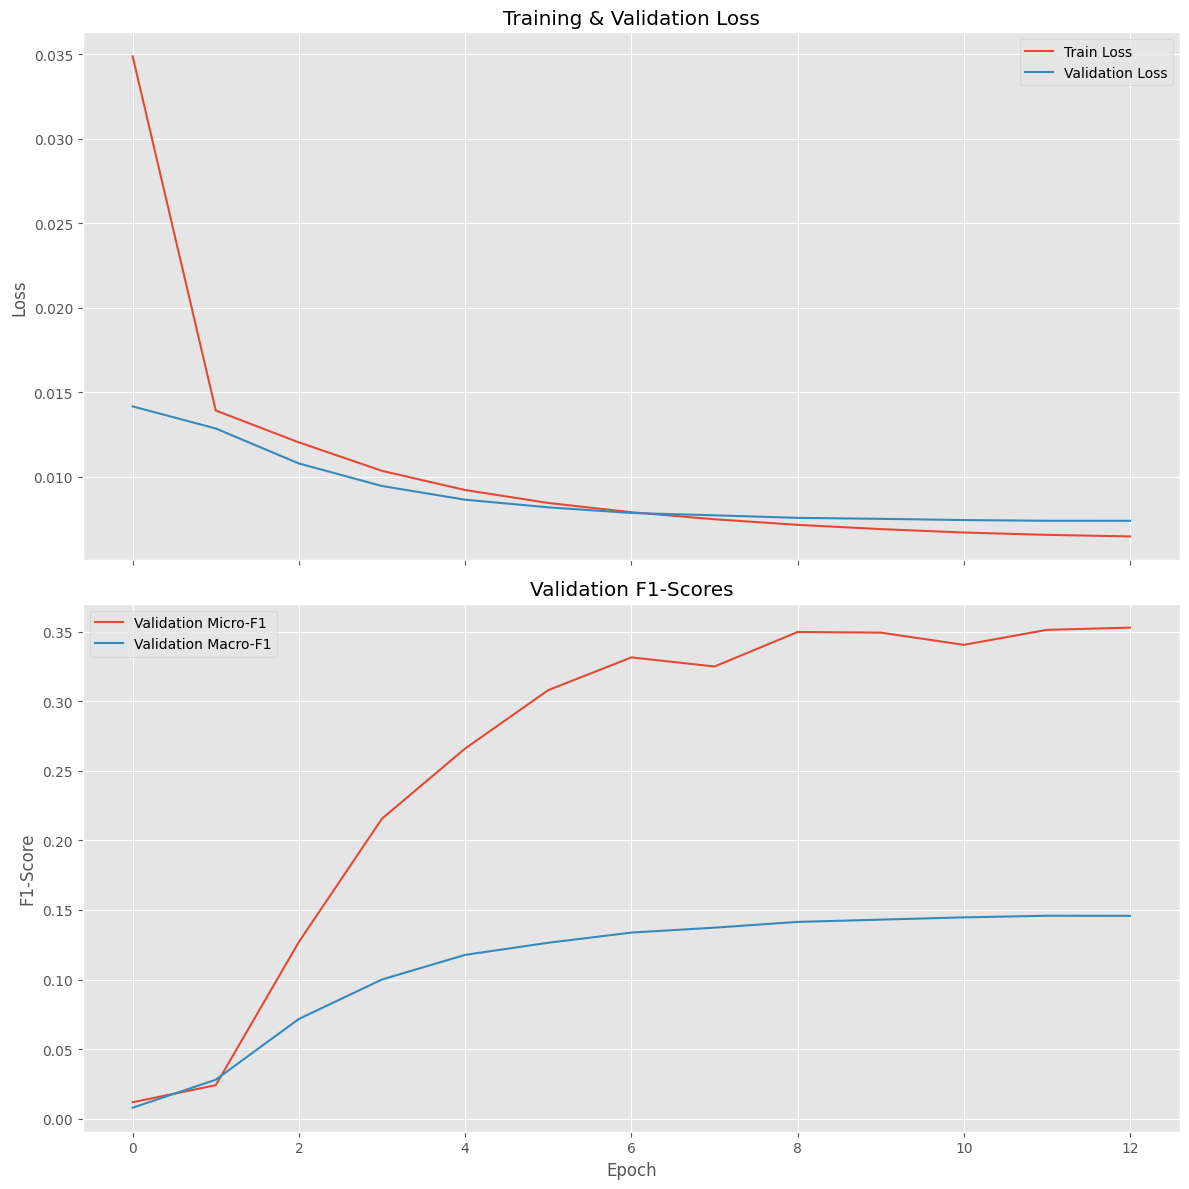

In [17]:
#--- 8. Plot Training History ---
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_ylabel("Loss")
ax1.set_title("Training & Validation Loss")
ax1.legend()

# Plot F1-Score
ax2.plot(history['val_f1_micro'], label='Validation Micro-F1')
ax2.plot(history['val_f1_macro'], label='Validation Macro-F1')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-Score")
ax2.set_title("Validation F1-Scores")
ax2.legend()

plt.tight_layout()
plt.show()